# Training Notebook for Adaptive Travel Recommendation with RL

This notebook trains three reinforcement learning models:
- **Epsilon-Greedy**
- **LinUCB (Contextual Bandit)**
- **Thompson Sampling**

Using user profiles from the generated dataset.

## Import Libraries

In [50]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Import agent classes from models module
from models.agents import EpsilonGreedyAgent, LinUCBAgent, ContextualThompsonSampling

## Load Data and Setup

In [51]:
# Load user profiles
df_users = pd.read_csv('../data/gen/user_profiles.csv')
print("Loaded user profiles:")
print(df_users.head())
print(f"\nTotal users: {len(df_users)}")

# Extract feature names (preference types)
feature_columns = [col for col in df_users.columns if col != 'user_id']
print(f"\nFeature types: {feature_columns}")

Loaded user profiles:
   user_id      biển  chụp ảnh   di tích   du lịch  khám phá   lịch sử  \
0        0  0.067027  0.168003  0.020411  0.076881  0.066286  0.062801   
1        1  0.016196  0.044113  0.038532  0.023509  0.295075  0.037883   
2        2  0.142153  0.020295  0.209957  0.046080  0.038689  0.029396   
3        3  0.021911  0.071755  0.030093  0.056690  0.119094  0.112328   
4        4  0.011863  0.130945  0.117155  0.050885  0.062300  0.026804   

   tham quan  thiên nhiên  thư giãn  vui chơi   văn hóa  yên bình  
0   0.008696     0.067819  0.018986  0.030531  0.109801  0.302758  
1   0.214394     0.018790  0.152920  0.003863  0.150402  0.004322  
2   0.136732     0.033354  0.112727  0.131343  0.020306  0.078968  
3   0.126552     0.004704  0.299282  0.017284  0.113716  0.026589  
4   0.163789     0.007769  0.011274  0.174726  0.026933  0.215556  

Total users: 20

Feature types: ['biển', 'chụp ảnh', 'di tích', 'du lịch', 'khám phá', 'lịch sử', 'tham quan', 'thiên nhiên'

In [52]:
# Load places from final_dataset.csv
df_places = pd.read_csv('../data/final_dataset.csv')
print("Loaded places from final_dataset.csv:")
print(df_places.head())
print(f"\nTotal places: {len(df_places)}")

# Convert dataset to places format
places = []
for _, row in df_places.iterrows():
    # Extract the first keyword as the primary type
    keywords = row['Keywords'].split(', ')
    primary_type = keywords[0] if keywords else 'du lịch'
    places.append({
        "name": row['Location Name'],
        "type": primary_type,
        "keywords": keywords,
        "rating": row['Rating']
    })

print(f"\nTotal places (arms): {len(places)}")
print(f"\nFirst 10 places:")
for i, place in enumerate(places[:10]):
    print(f"  {i}: {place['name']} - {place['type']} (rating: {place['rating']:.2f})")

Loaded places from final_dataset.csv:
          Location Name                                        Keywords  \
0      Bãi Dài Cam Ranh                        biển, vui chơi, chụp ảnh   
1       Tháp Bà Ponagar           tham quan, chụp ảnh, di tích, văn hóa   
2   Thành cổ Diên Khánh  tham quan, di tích, lịch sử, chụp ảnh, văn hóa   
3  VinWonders Nha Trang                              vui chơi, chụp ảnh   
4            Suối Ba Hồ                              chụp ảnh, vui chơi   

   Rating  
0    0.96  
1    0.90  
2    0.90  
3    0.92  
4    0.86  

Total places: 141

Total places (arms): 141

First 10 places:
  0: Bãi Dài Cam Ranh - biển (rating: 0.96)
  1: Tháp Bà Ponagar - tham quan (rating: 0.90)
  2: Thành cổ Diên Khánh - tham quan (rating: 0.90)
  3: VinWonders Nha Trang - vui chơi (rating: 0.92)
  4: Suối Ba Hồ - chụp ảnh (rating: 0.86)
  5: Đảo Phú Quốc  - biển (rating: 0.96)
  6: Biển Mũi Nai - biển (rating: 0.94)
  7: Chùa Láng Cát - tham quan (rating: 0.88)
  8: Vườn q

In [53]:
# Show distribution of place types
place_types = [p['type'] for p in places]
type_counts = pd.Series(place_types).value_counts()
print(f"\nPlace type distribution:")
print(type_counts.head(15))

print(f"\nUnique place types: {len(type_counts)}")


Place type distribution:
tham quan      52
lịch sử        24
khám phá       14
biển           10
chụp ảnh       10
thiên nhiên     9
du lịch         8
thư giãn        8
di tích         4
vui chơi        1
văn hóa         1
Name: count, dtype: int64

Unique place types: 11


In [54]:
# Convert DataFrame to user profile dictionaries
user_profiles = []
for _, row in df_users.iterrows():
    user_id = int(row['user_id'])
    prefs = {col: row[col] for col in feature_columns}
    user_profiles.append({"id": user_id, "prefs": prefs})

print(f"Created {len(user_profiles)} user profiles")
print(f"\nExample user profile (User 0):")
print(user_profiles[0])

Created 20 user profiles

Example user profile (User 0):
{'id': 0, 'prefs': {'biển': 0.0670272546740832, 'chụp ảnh': 0.1680026591480587, 'di tích': 0.0204112406897736, 'du lịch': 0.0768805336112714, 'khám phá': 0.0662855043154245, 'lịch sử': 0.0628011192585772, 'tham quan': 0.0086958076913237, 'thiên nhiên': 0.0678190841624718, 'thư giãn': 0.0189864482876448, 'vui chơi': 0.0305312333689249, 'văn hóa': 0.1098014536891935, 'yên bình': 0.3027576611032523}}


In [55]:
# Reward simulation function
def simulate_reward(user, place):
    """
    Reward = 1 if user clicks/rates high, otherwise low
    Probability of reward depends on preference match between user and place
    """
    pref_score = user["prefs"].get(place["type"], 0)
    place_r = np.clip(place.get("rating", 3.0) / 5.0, 0, 1)
    utility = 0.7 * pref_score + 0.3 * place_r
    prob = np.clip(utility + np.random.normal(0, 0.05), 0, 1)

    rating = int(np.floor(prob * 5)) + 1
    rating = max(1, min(5, rating))

    return rating

## Model 1: Epsilon-Greedy Agent

In [56]:
def train_epsilon_greedy(agent, n_rounds=1000):
    """Train Epsilon-Greedy agent"""
    user_rewards = {u["id"]: [] for u in user_profiles}
    avg_rewards = []
    arm_history = []

    for round_num in range(n_rounds):
        user = random.choice(user_profiles)
        ranked = agent.select_arm()

        # if round_num < int(0.9 * n_rounds):
        chosen_arm = random.choice(ranked)
        rating_sim = simulate_reward(user, places[chosen_arm])
        rating_norm = (rating_sim - 1) / 4

        reward = 1.0 + rating_norm

        agent.update(chosen_arm, reward)
        user_rewards[user["id"]].append(reward)
        arm_history.append(chosen_arm)

        for arm in ranked:
            if arm != chosen_arm:
                agent.update(arm, -0.3)
                user_rewards[user["id"]].append(-0.3)
                arm_history.append(arm)
        
        # else:
        #     print(f"--- Round {round_num+1}/{n_rounds} ---")
        #     print(f"User: {user['id']}")
        #     print("Top 3 Recommendation:", [places[i]["name"] for i in ranked])
        #     for i, arm in enumerate(ranked):
        #         print(f" {i}. {places[arm]['name']} (Scores: {agent.values[arm]:.3f})")

        #     chosen = int(input(f"Choose the location you favorite: (0-{len(ranked)-1}): "))
        #     chosen_arm = ranked[chosen]

        #     rating = float(input("Rating the location you choose (1-5): "))
        #     rating_norm = (rating - 1) / 4
        #     reward = 1 + rating_norm

        #     agent.update(chosen_arm, reward)
        #     user_rewards[user["id"]].append(reward)
        #     arm_history.append(chosen_arm)

        #     for arm in ranked:
        #         if arm != chosen_arm:
        #             agent.update(arm, -0.3)
        #             user_rewards[user["id"]].append(-0.3)
        #             arm_history.append(arm)

        avg_rewards.append(np.mean([r for lst in user_rewards.values() for r in lst]))

    print(f"Epsilon-Greedy training done! Final avg reward: {np.mean(avg_rewards[-100:]):.3f}")
    return agent, user_rewards, avg_rewards, arm_history

## Model 2: LinUCB Agent

In [57]:
def context_to_vector(user):
    """Convert user preferences to vector"""
    return np.array([user["prefs"].get(col, 0) for col in feature_columns])

In [58]:
def train_linucb(agent, n_rounds=1000):
    """Train LinUCB agent"""
    user_rewards = {u["id"]: [] for u in user_profiles}
    avg_rewards = []
    arm_history = []

    for round_num in range(n_rounds):
        user = random.choice(user_profiles)
        x = context_to_vector(user)

        # Select top-3 recommendations
        ranked, score = agent.select_arm(x)

        # if round_num < int(0.9 * n_rounds):
        chosen_arm = random.choice(ranked)
        rating_sim = simulate_reward(user, places[chosen_arm])
        rating_norm = (rating_sim - 1) / 4

        reward = 1 + rating_norm

        agent.update(chosen_arm, x, reward)
        user_rewards[user["id"]].append(reward)
        arm_history.append(chosen_arm)

        for arm in ranked:
            if arm != chosen_arm:
                agent.update(arm, x, -0.3)
                user_rewards[user["id"]].append(-0.3)
                arm_history.append(arm)

        # else:
        #     print(f"--- Round {round_num + 1}/{n_rounds} ---")
        #     print(f"User: {user['id']}")
        #     print("Top 3 Recommendations:")
        #     for i, arm in enumerate(ranked):
        #         print(f" {i}. {places[arm]['name']} (Scores: {score[arm]:.3f})")

        #     chosen = int(input(f"Choose the location you like (0-{len(ranked)-1}): "))
        #     chosen_arm = ranked[chosen]

        #     rating = float(input("Rate the chosen location (1-5): "))
        #     rating_norm = (rating - 1) / 4
        #     reward = 1 + rating_norm

        #     agent.update(chosen_arm, x, reward)
        #     user_rewards[user["id"]].append(reward)
        #     arm_history.append(chosen_arm)

        #     for arm in ranked:
        #         if arm != chosen_arm:
        #             agent.update(arm, x, -0.3)
        #             user_rewards[user["id"]].append(-0.3)
        #             arm_history.append(arm)

        avg_rewards.append(np.mean([r for lst in user_rewards.values() for r in lst]))

    print(f"LinUCB training done! Final avg reward: {np.mean(avg_rewards[-100:]):.3f}")
    return agent, user_rewards, avg_rewards, arm_history

## Model 3: Thompson Sampling Agent

In [59]:
def train_thompson_sampling(agent, n_rounds=1000):
    """Train Thompson Sampling agent"""
    user_rewards = {u["id"]: [] for u in user_profiles}
    avg_rewards = []
    arm_history = []

    for round_num in range(n_rounds):
        user = random.choice(user_profiles)
        x = context_to_vector(user)

        # Select top-3 recommendations
        ranked, score = agent.select_arm(x)

        # if round_num < int(0.9 * n_rounds):
        chosen_arm = random.choice(ranked)
        rating_sim = simulate_reward(user, places[chosen_arm])
        rating_norm = (rating_sim - 1) / 4

        reward = 1 + rating_norm

        agent.update(chosen_arm, x, reward)
        user_rewards[user["id"]].append(reward)
        arm_history.append(chosen_arm)

        for arm in ranked:
            if arm != chosen_arm:
                agent.update(arm, x, -0.3)
                user_rewards[user["id"]].append(-0.3)
                arm_history.append(arm)

        # else:
        #     print(f"--- Round {round_num + 1}/{n_rounds} ---")
        #     print(f"User: {user['id']}")
        #     print("Top 3 Recommendations:")
        #     for i, arm in enumerate(ranked):
        #         print(f" {i}. {places[arm]['name']} (Scores: {score[arm]:.3f})")

        #     chosen = int(input(f"Choose the location you like (0-{len(ranked)-1}): "))
        #     chosen_arm = ranked[chosen]

        #     rating = float(input("Rate the chosen location (1-5): "))
        #     rating_norm = (rating - 1) / 4
        #     reward = 1 + rating_norm

        #     agent.update(chosen_arm, x, reward)
        #     user_rewards[user["id"]].append(reward)
        #     arm_history.append(chosen_arm)

        #     for arm in ranked:
        #         if arm != chosen_arm:
        #             agent.update(arm, x, -0.3)
        #             user_rewards[user["id"]].append(-0.3)
        #             arm_history.append(arm)

        avg_rewards.append(np.mean([r for lst in user_rewards.values() for r in lst]))

    print(f"Thompson Sampling training done! Final avg reward: {np.mean(avg_rewards[-100:]):.3f}")
    return agent, user_rewards, avg_rewards, arm_history

## Train All Models

In [60]:
# Set training parameters
N_ROUNDS = 2000

print("=" * 60)
print("TRAINING ALL MODELS")
print("=" * 60)
print(f"Number of rounds: {N_ROUNDS}")
print(f"Number of users: {len(user_profiles)}")
print(f"Number of places (arms): {len(places)}")
print(f"Number of features: {len(feature_columns)}")
print("=" * 60)

TRAINING ALL MODELS
Number of rounds: 2000
Number of users: 20
Number of places (arms): 141
Number of features: 12


In [61]:
# Train Epsilon-Greedy
print("\n 1  Training Epsilon-Greedy...")
agent_egreedy = EpsilonGreedyAgent(n_arms=len(places), epsilon=0.2)
agent_egreedy, user_rewards_eg, avg_rewards_eg, arm_history_eg = train_epsilon_greedy(agent_egreedy, n_rounds=N_ROUNDS)


 1  Training Epsilon-Greedy...


Epsilon-Greedy training done! Final avg reward: 0.146


In [62]:
# Train LinUCB
print("\n 2  Training LinUCB...")
agent_linucb = LinUCBAgent(n_arms=len(places), n_features=len(feature_columns), alpha=0.1)
agent_linucb, user_rewards_linucb, avg_rewards_linucb, arm_history_linucb = train_linucb(agent_linucb, n_rounds=N_ROUNDS)


 2  Training LinUCB...
LinUCB training done! Final avg reward: 0.151


In [63]:
# Train Thompson Sampling
print("\t 3  Training Thompson Sampling...")
agent_ts = ContextualThompsonSampling(n_arms=len(places), d=len(feature_columns), alpha=0.1)
agent_ts, user_rewards_ts, avg_rewards_ts, arm_history_ts = train_thompson_sampling(agent_ts, n_rounds=N_ROUNDS)

	 3  Training Thompson Sampling...
Thompson Sampling training done! Final avg reward: 0.146


## Visualization: Learning Curves (Average Reward)

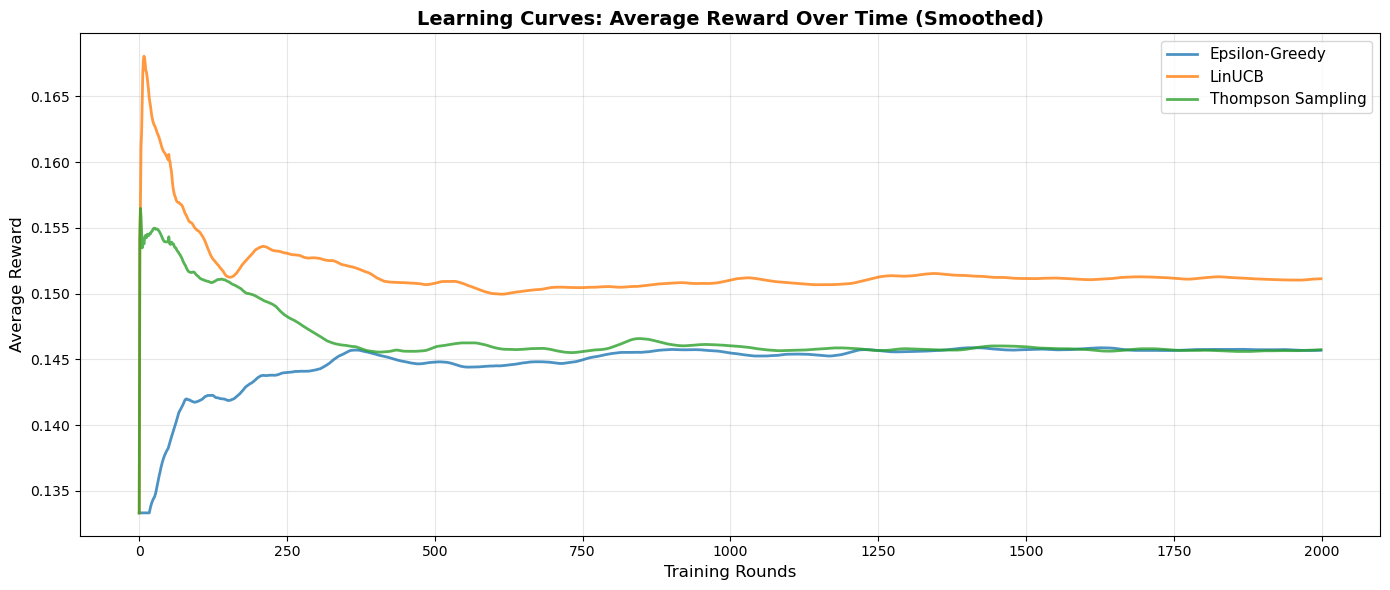

In [64]:
def plot_learning_curves(avg_rewards_eg, avg_rewards_linucb, avg_rewards_ts):
    """Plot average reward over time for all models"""
    plt.figure(figsize=(14, 6))
    
    # Smooth the curves with moving average
    window = 50
    
    def smooth(data, window):
        return pd.Series(data).rolling(window=window, min_periods=1).mean()
    
    plt.plot(smooth(avg_rewards_eg, window), label='Epsilon-Greedy', linewidth=2, alpha=0.8)
    plt.plot(smooth(avg_rewards_linucb, window), label='LinUCB', linewidth=2, alpha=0.8)
    plt.plot(smooth(avg_rewards_ts, window), label='Thompson Sampling', linewidth=2, alpha=0.8)
    
    plt.xlabel('Training Rounds', fontsize=12)
    plt.ylabel('Average Reward', fontsize=12)
    plt.title('Learning Curves: Average Reward Over Time (Smoothed)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_learning_curves(avg_rewards_eg, avg_rewards_linucb, avg_rewards_ts)

## Visualization: Cumulative Average Reward

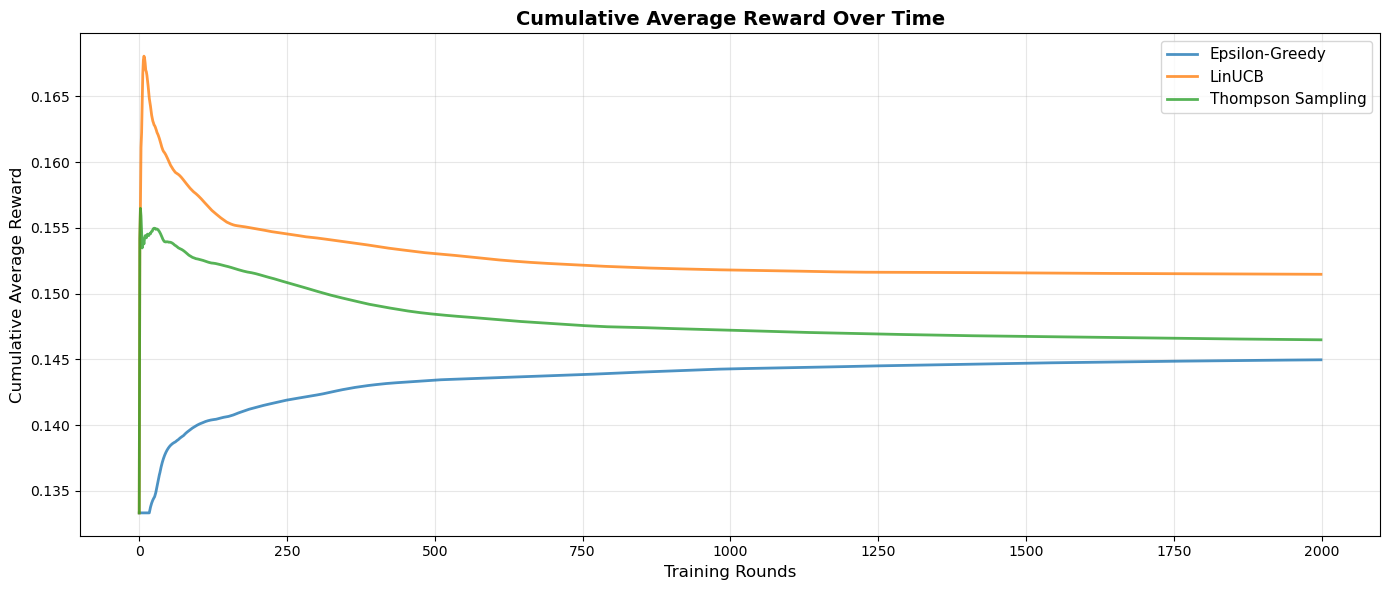

In [65]:
def plot_cumulative_rewards(avg_rewards_eg, avg_rewards_linucb, avg_rewards_ts):
    """Plot cumulative average reward"""
    plt.figure(figsize=(14, 6))
    
    cum_eg = np.cumsum(avg_rewards_eg) / np.arange(1, len(avg_rewards_eg) + 1)
    cum_linucb = np.cumsum(avg_rewards_linucb) / np.arange(1, len(avg_rewards_linucb) + 1)
    cum_ts = np.cumsum(avg_rewards_ts) / np.arange(1, len(avg_rewards_ts) + 1)
    
    plt.plot(cum_eg, label='Epsilon-Greedy', linewidth=2, alpha=0.8)
    plt.plot(cum_linucb, label='LinUCB', linewidth=2, alpha=0.8)
    plt.plot(cum_ts, label='Thompson Sampling', linewidth=2, alpha=0.8)
    
    plt.xlabel('Training Rounds', fontsize=12)
    plt.ylabel('Cumulative Average Reward', fontsize=12)
    plt.title('Cumulative Average Reward Over Time', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_cumulative_rewards(avg_rewards_eg, avg_rewards_linucb, avg_rewards_ts)

## Visualization: Per-User Performance

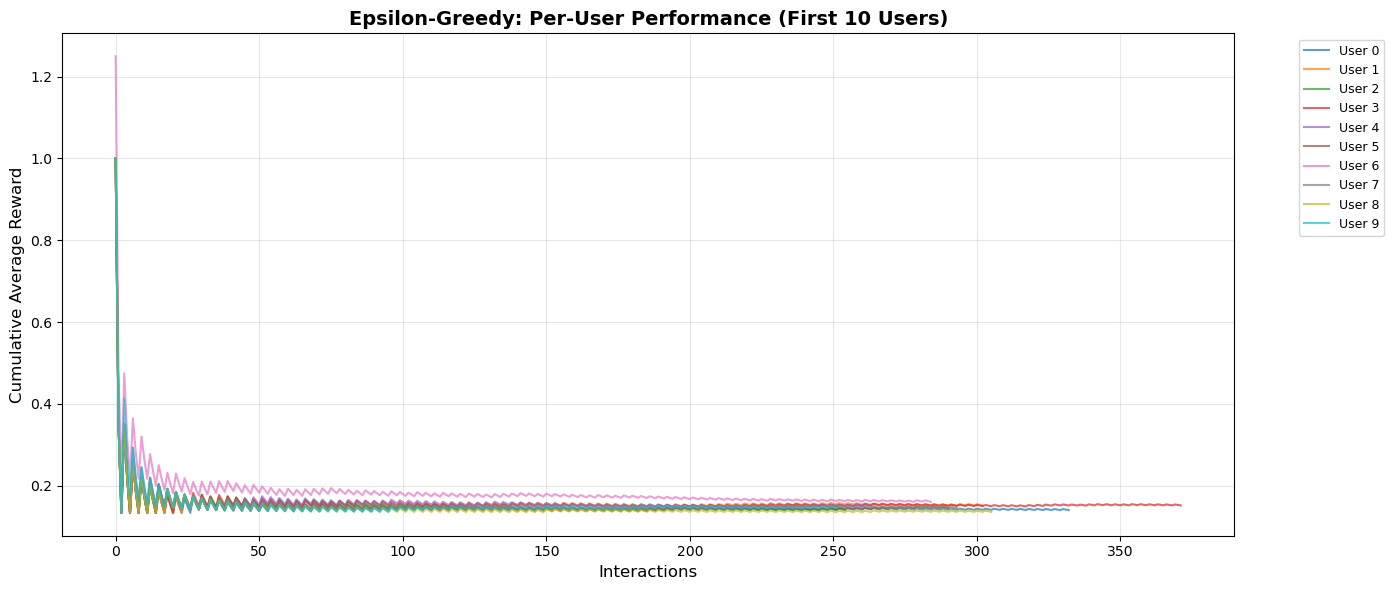

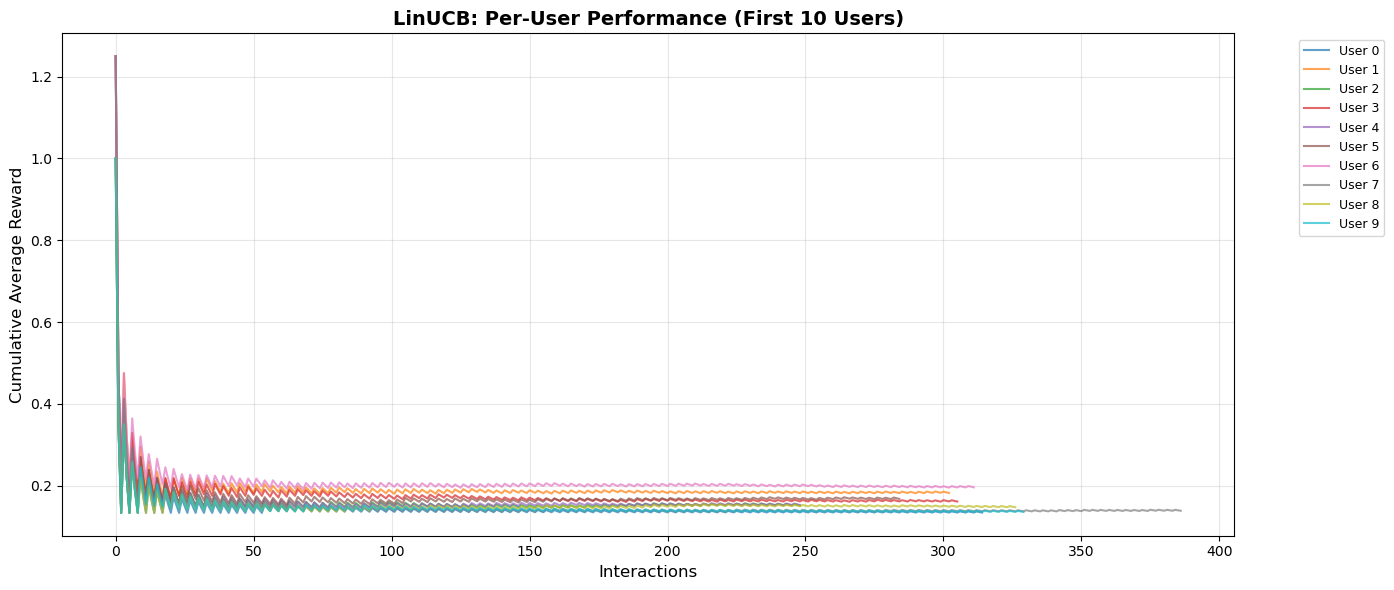

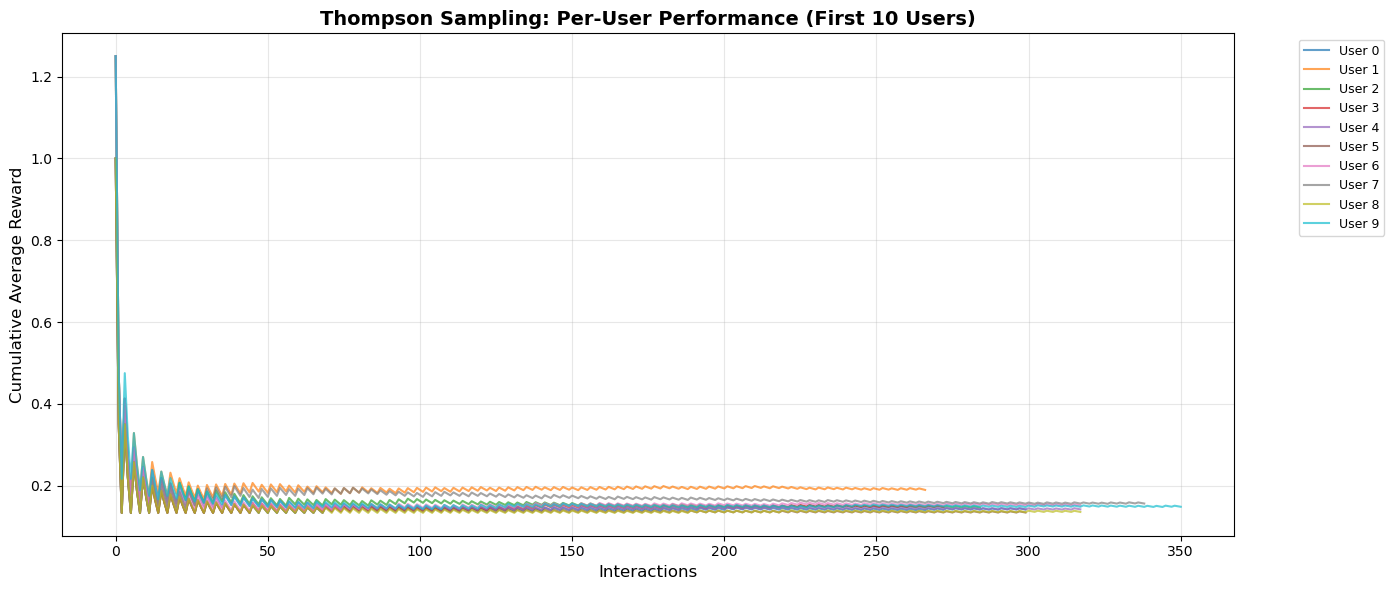

In [66]:
def plot_per_user_rewards(user_rewards_dict, model_name, n_users=10):
    """Plot per-user average rewards"""
    plt.figure(figsize=(14, 6))
    
    for uid in range(min(n_users, len(user_rewards_dict))):
        if len(user_rewards_dict[uid]) > 0:
            cum_rewards = np.cumsum(user_rewards_dict[uid]) / np.arange(1, len(user_rewards_dict[uid]) + 1)
            plt.plot(cum_rewards, label=f'User {uid}', alpha=0.7)
    
    plt.xlabel('Interactions', fontsize=12)
    plt.ylabel('Cumulative Average Reward', fontsize=12)
    plt.title(f'{model_name}: Per-User Performance (First {n_users} Users)', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot for each model
plot_per_user_rewards(user_rewards_eg, "Epsilon-Greedy", n_users=10)
plot_per_user_rewards(user_rewards_linucb, "LinUCB", n_users=10)
plot_per_user_rewards(user_rewards_ts, "Thompson Sampling", n_users=10)

## Visualization: Model Comparison

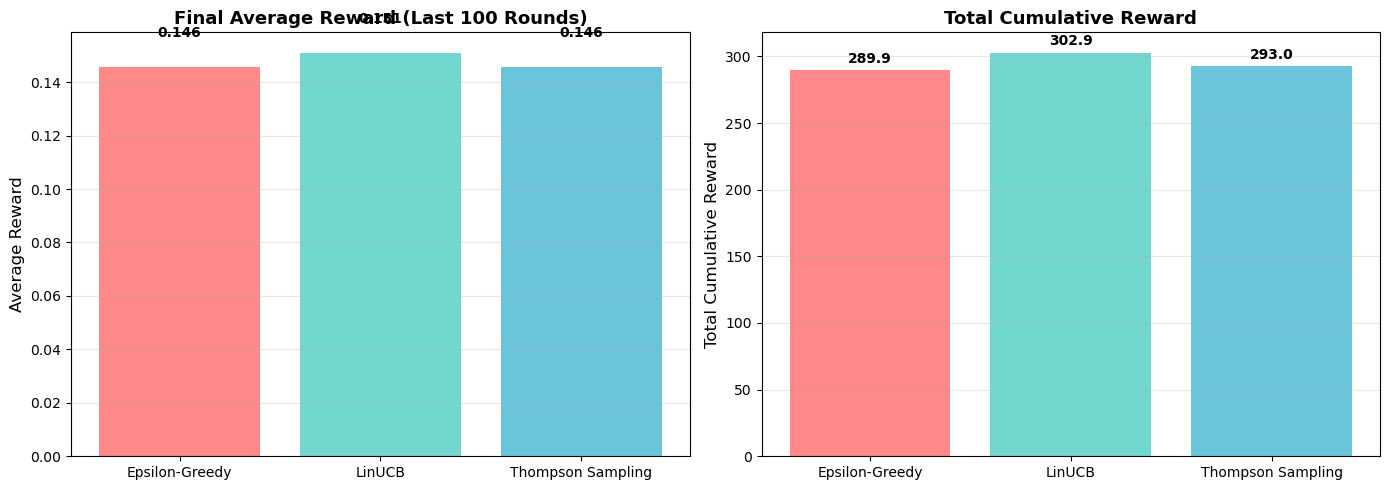


MODEL PERFORMANCE SUMMARY
Epsilon-Greedy       | Final Avg:  0.146 | Total:    289.9
LinUCB               | Final Avg:  0.151 | Total:    302.9
Thompson Sampling    | Final Avg:  0.146 | Total:    293.0


In [67]:
def compare_models():
    """Compare final performance metrics of all models"""
    models = ['Epsilon-Greedy', 'LinUCB', 'Thompson Sampling']
    
    # Calculate final average rewards (last 100 rounds)
    final_rewards = [
        np.mean(avg_rewards_eg[-100:]),
        np.mean(avg_rewards_linucb[-100:]),
        np.mean(avg_rewards_ts[-100:])
    ]
    
    # Calculate total cumulative rewards
    total_rewards = [
        np.sum(avg_rewards_eg),
        np.sum(avg_rewards_linucb),
        np.sum(avg_rewards_ts)
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Final average reward comparison
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    axes[0].bar(models, final_rewards, color=colors, alpha=0.8)
    axes[0].set_ylabel('Average Reward', fontsize=12)
    axes[0].set_title('Final Average Reward (Last 100 Rounds)', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(final_rewards):
        axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Total cumulative reward comparison
    axes[1].bar(models, total_rewards, color=colors, alpha=0.8)
    axes[1].set_ylabel('Total Cumulative Reward', fontsize=12)
    axes[1].set_title('Total Cumulative Reward', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(total_rewards):
        axes[1].text(i, v + max(total_rewards)*0.01, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "=" * 60)
    print("MODEL PERFORMANCE SUMMARY")
    print("=" * 60)
    for i, model in enumerate(models):
        print(f"{model:20s} | Final Avg: {final_rewards[i]:6.3f} | Total: {total_rewards[i]:8.1f}")
    print("=" * 60)

compare_models()

## Visualization: Arm Selection Distribution

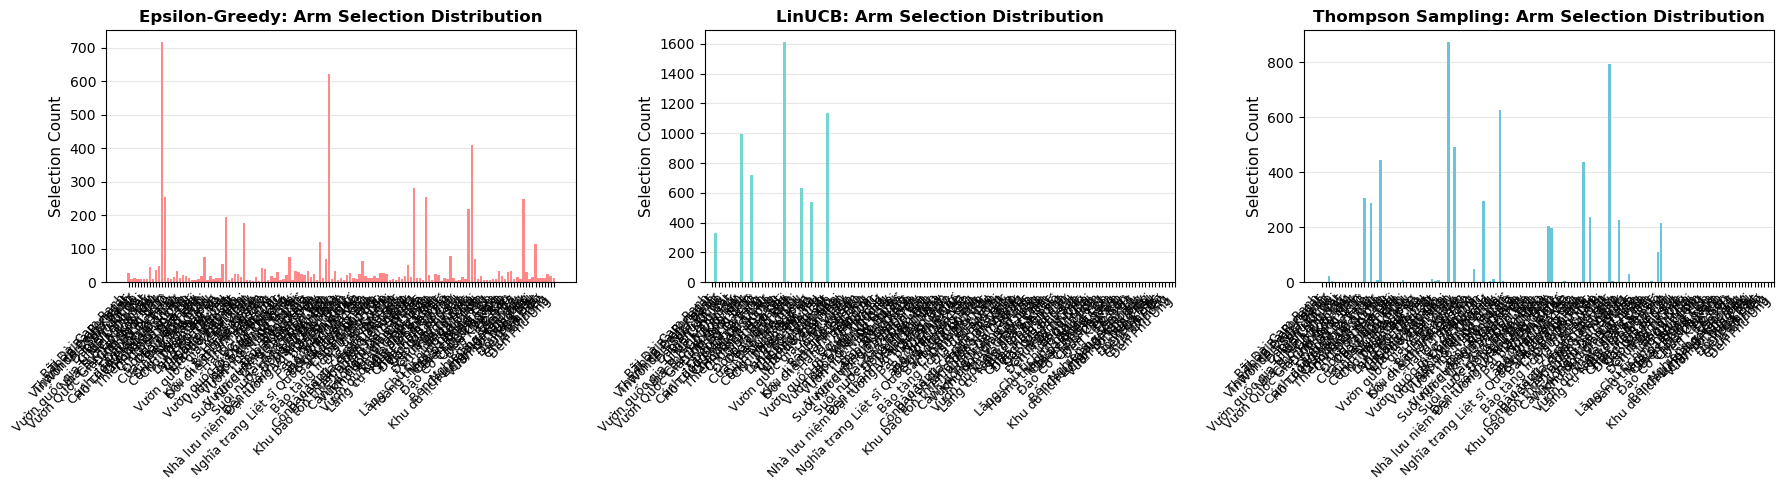

In [68]:
def plot_arm_distribution(arm_history_eg, arm_history_linucb, arm_history_ts):
    """Plot distribution of arm selections"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    place_names = [p['name'] for p in places]
    
    # Epsilon-Greedy
    counts_eg = pd.Series(arm_history_eg).value_counts().sort_index()
    axes[0].bar(range(len(counts_eg)), counts_eg.values, color='#FF6B6B', alpha=0.8)
    axes[0].set_xticks(range(len(place_names)))
    axes[0].set_xticklabels(place_names, rotation=45, ha='right', fontsize=9)
    axes[0].set_ylabel('Selection Count', fontsize=11)
    axes[0].set_title('Epsilon-Greedy: Arm Selection Distribution', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # LinUCB
    counts_linucb = pd.Series(arm_history_linucb).value_counts().sort_index()
    axes[1].bar(range(len(counts_linucb)), counts_linucb.values, color='#4ECDC4', alpha=0.8)
    axes[1].set_xticks(range(len(place_names)))
    axes[1].set_xticklabels(place_names, rotation=45, ha='right', fontsize=9)
    axes[1].set_ylabel('Selection Count', fontsize=11)
    axes[1].set_title('LinUCB: Arm Selection Distribution', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Thompson Sampling
    counts_ts = pd.Series(arm_history_ts).value_counts().sort_index()
    axes[2].bar(range(len(counts_ts)), counts_ts.values, color='#45B7D1', alpha=0.8)
    axes[2].set_xticks(range(len(place_names)))
    axes[2].set_xticklabels(place_names, rotation=45, ha='right', fontsize=9)
    axes[2].set_ylabel('Selection Count', fontsize=11)
    axes[2].set_title('Thompson Sampling: Arm Selection Distribution', fontsize=12, fontweight='bold')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

plot_arm_distribution(arm_history_eg, arm_history_linucb, arm_history_ts)

## Save Trained Models (Optional)

In [69]:
import pickle
import os

# Create saved_models directory if it doesn't exist
os.makedirs('../saved_models', exist_ok=True)

# Save models
with open('../saved_models/epsilon_greedy.pkl', 'wb') as f:
    pickle.dump(agent_egreedy, f)
    
with open('../saved_models/linucb.pkl', 'wb') as f:
    pickle.dump(agent_linucb, f)
    
with open('../saved_models/thompson_sampling.pkl', 'wb') as f:
    pickle.dump(agent_ts, f)

print("✅ Models saved successfully!")
print("  - ../saved_models/epsilon_greedy.pkl")
print("  - ../saved_models/linucb.pkl")
print("  - ../saved_models/thompson_sampling.pkl")

✅ Models saved successfully!
  - ../saved_models/epsilon_greedy.pkl
  - ../saved_models/linucb.pkl
  - ../saved_models/thompson_sampling.pkl
